In [11]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score

# Helpers

In [12]:
def print_scores(test_Y,predictions):
    print("ROC AUC score:", roc_auc_score(test_Y, predictions))


#### Split the data
def split_train_test(df, target_name, id_var_name, test_size):

    # Split X and Y into training and testing datasets
    train, test = train_test_split(df, test_size = test_size, random_state = 42, stratify = df[target_name])
    
    # Store column names from `telcom` excluding target variable and customer ID
    cols = [col for col in df.columns if col not in [id_var_name] + [target_name]]
    
    # Extract training features
    train_X = train[cols]
    
    # Extract training target
    train_Y = train[target_name]
    
    # Extract testing features
    test_X = test[cols]
    
    # Extract testing target
    test_Y = test[target_name]
    
    return(train_X, train_Y, test_X, test_Y)

## Conteúdo

- [1. Dependências](#1)
- [2. Analisar e preparar os dados](#2)
    - [2.1. Lidar com poucas informações utéis](#2-1)
    - [2.2. Escolher a estratégia de modelização que atende ao problema](#2-2)
    - [2.3.  Problema de balanceamento](#2-3)
- [3. A fase de modelagem](#3)
    - [3.1. Dividir o dataset](#3-1)
    - [3.2. Os modelos](#3-2)
      * [3.2.1. Random Forest](#3-2-1)
      * [3.2.2. Gradient Boost](#3-2-2)
    - [3.3 Otimizar o modelo mais promissor](#3-3)
- [4. Resolução do caso](#4)
    - [4.1. Maximizar o lucro esperado por cliente](#4-1)
    - [4.2. Atribuir uma nota de 1 a 5 para cada cliente](#4-2)
    - [4.3. Encontrar os três grupos naturais que possuem os maiores lucros](#4-3)

<a name='1'></a>
## 1. Dependências

Primeiro, importaremos todos os pacotes que precisamos para este projeto.  

- `sklearn` é uma biblioteca popular de machine learning.
- `numpy` é um pacote fundamental para computação em Python.
- `seaborn` é uma biblioteca de gráficos.
- `matplotlib` é uma biblioteca de gráficos.
- `pandas` é uma ferramenta de manipulação e análise de dados.
- `autosklearn` é um kit de ferramentas de machine learning automatizado.
- `joblib` é um conjunto de ferramentas para fornecer pipelining leve em Python.
- `xgboost` é uma biblioteca otimizada de gradient boosting.
- `skopt` é uma ferramenta de pesquisa de hiperparâmetro utilizando scikit-learn.
- `math` é uma biblioteca de funções matemáticas.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from joblib import dump, load
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from math import sqrt

<a name='2'></a>
## 2. Análisar e preparar os dados

Uma primeira análise do <em>dataset</em> revela as imperfeições. Vamos preparar o <em>dataset</em> para a fase de modelização.

<a name='2-1'></a>

### 2.1.  Lidar com poucas informações utéis

In [3]:
train_df = pd.read_csv('/home/container/t732787/Auto ML Tests/data/santander_customer_satisfaction.csv.zip')
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
target_name = 'TARGET'
id_var_name = 'ID'

In [6]:
sum(train_df.isnull().sum() == 0) == train_df.shape[1]

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


True

O <em>dataset</em> não tem <em>missing values</em>.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


Os únicos tipos são <em>int</em> e <em>float</em>.  
De fato, os estimadores da biblioteca `scikit-learn` aceitam todas as colunas: não precisamos utilizar <em>encoding</em>\.  
Dentro das 260 colunas de tipo <em>int64</em>, deve ter algumas que representam categorias.  
As colunas não tem nomes intuitivos, porém talvez dê para adivinhar quais <em>features</em> são categorias com a quantidade de valores que elas recebem:

In [8]:
train_df.nunique().sort_values()

ind_var41                    1
num_var46                    1
imp_amort_var18_hace3        1
num_var28_0                  1
num_var28                    1
                         ...  
saldo_var42              15730
saldo_var30              16940
saldo_medio_var5_ult3    17330
var38                    57736
ID                       76020
Length: 371, dtype: int64

In [230]:
categorical = train_df.nunique()[train_df.nunique() < 10].keys().to_list()
print(len(categorical))

categorical = train_df.nunique()[train_df.nunique() < 20].keys().to_list()
print(len(categorical))

categorical = train_df.nunique()[train_df.nunique() < 30].keys().to_list()
print(len(categorical))

204
218
234


É dificil separar as categorias do resto deste <em>dataset</em>\.  
Por consequência, não podemos identificar em quais colunas aplicar normalização ou `one-hot-encoding`\.  
De fato, é melhor desconsiderar os modelos que utilizam distâncias na função de custo durante a fase de modelagem.  

In [281]:
constants = train_df.columns[train_df.nunique() == 1]
constants

Index(['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28',
       'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0',
       'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0',
       'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46',
       'imp_amort_var18_hace3', 'imp_amort_var34_hace3',
       'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3',
       'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3',
       'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3',
       'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3',
       'num_trasp_var33_out_hace3', 'saldo_var2_ult1',
       'saldo_medio_var13_medio_hace3'],
      dtype='object')

Essas colunas com um valor unico não ajudarão nas previsões\.  
Podemos desconsidera-las:

In [282]:
train_df = train_df.drop(constants, axis=1)
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


A quantidade de colunas esta muita grande ainda\.  
Não vamos correr o risco de deixar colunas duplicadas, o que induziria um bias importante nos treinamentos do modelo.

In [283]:
# remove duplicated columns
duplicated = []
c = train_df.columns
for i in range(len(c)-1):
    v = train_df[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,train_df[c[j]].values):
            duplicated.append(c[j])
train_df.drop(duplicated, axis=1, inplace=True)

train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


Precebemos que muitos zeros persistem nas colunas\.  
Vamos somar a quantidade de zeros por linhas:

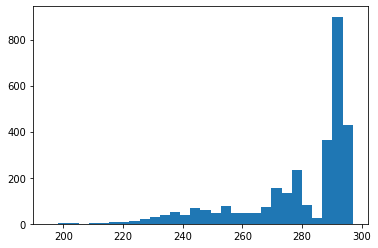

In [243]:
plt.hist((train_df[train_df[target_name] == 1] == 0).sum(axis=1), bins=30)
plt.show()

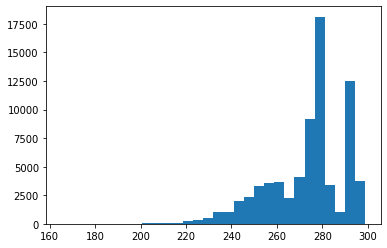

In [244]:
plt.hist((train_df[train_df[target_name] == 0] == 0).sum(axis=1), bins=30)
plt.show()

Reparamos que a maior parte dos clientes insatisfeitos tem 290 ou mais valores 0 na linha\.  
De fato, muitas colunas podem referenciar produtos e parece logico que um cliente insatisfeito paga poucos produtos\.  
Vamos adicionar a soma horizontal dos zeros como novo <em>feature</em>:

In [245]:
train_df['n0'] = (train_df.drop([id_var_name, target_name], axis=1) == 0).sum(axis=1)
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET,n0
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0,292
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0,266
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0,277
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0,248
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0,256


Seguindo o mesmo raciocinio, a soma dos <em>integers</em> e dos <em>floats</em> em cada linha deveria agregar informação\.  
Existe tambêm o risco de induzir um <em>bias</em> por causa das colunas <em>integers</em> que representam categorias\.  
Mas ja verificamos a importancia associada aos novos <em>features</em> depois do processo. 

In [246]:
# count of integers row-wise
integer_cols = train_df.columns[train_df.dtypes == 'int64']
train_df['nInt'] = (train_df[integer_cols].drop([id_var_name, target_name, "n0"], axis=1) ).sum(axis=1)
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET,n0,nInt
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0,292,145
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0,266,94
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0,277,162
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0,248,293
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0,256,135


In [247]:
# count of floats row-wise
float_cols = train_df.columns[train_df.dtypes == 'float64']
train_df['nFloat'] = (train_df[float_cols]).sum(axis=1)
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET,n0,nInt,nFloat
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,39205.170000,0,292,145,3.920517e+04
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,49278.030000,0,266,94,5.152789e+04
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,67333.770000,0,277,162,6.735102e+04
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,64007.970000,0,248,293,6.584127e+04
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,117310.979016,0,256,135,1.287339e+06


Nesse <em>dataset</em> existem muitas colunas que provavelmente não agregam muita informação quando isoladas\.  
Vamos utilizar a tecnica de `principal component analysis` para extrair o maximo de informação delas, com a projeção delas para uma dimensão reduzida.

In [248]:
pca = PCA(n_components=2)
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df.drop([id_var_name, target_name], axis=1))
X_pca = pca.fit_transform(train_df_scaled)
train_df['PCA1'] = X_pca[:,0]
train_df['PCA2'] = X_pca[:,1]

<a name='2-2'></a>

### 2.2.  Escolher a estratégia de modelização que atende ao problema

A árvore de decisão não precisa de nenhuma transformação do tipo (one-hot-encoding ou normalização das colunas)\.  
As árvores também não são sensíveis aos `outliers`, os quais possuem uma grande quantidade neste <em>dataset</em> (ver a figura da questão c)\.  
De fato, os modelos baseados em árvores serão o nosso foco ao longo das proximas etapas.

Um verdadeiro positivo rende R\\$ 90  
Enquanto um falso positivo custa R\\$ 10  

Considerando as seguintes quantidades:  
- `TP` : a quantidade de verdadeiros positivos  
- `FP` : a quantidade de falsos positivos  

O nosso objetivo é de maximizar a função:  
$G = TP \times 90 - FP \times 10$

Uma métrica que permite maximizar `TP` e minimizar `FP` é o `AUC`.  
O `AUC` é a area abaixo da curva `ROC` ($y = \frac{TP}{TP + FN}$ e $x = \frac{FP}{FP + TN}$)

<a name='2-3'></a>

### 2.3.  Problema de balanceamento

Um outro ponto que devemos levar em consideração é o balanceamento do <em>dataset</em>

In [58]:
#### Explore Not Satisfied rate (check if it's imbalanced)
def is_imbalanced(df, target_name, tolerance):
    """
    

    Parameters
    ----------
    df : pandas.Dataframe
        df.
    target_name : string
        target_name.
    tolerance : int
        Tolerance percentage.

    Returns
    -------
    boolean
        True if is imbalanced, else False.

    """
    # Print the unique Not Satisfied values
    print(set(df[target_name]))
    # Calculate the ratio size of each Not Satisfied group
    ratio_size = df.groupby([target_name]).size() / df.shape[0] * 100
    ratio_size_min = ratio_size[ratio_size.idxmin()]
    print(ratio_size)
    print(ratio_size_min)
    return (ratio_size_min <= tolerance)


imbalanced = is_imbalanced(train_df, target_name = target_name, tolerance = 30)
imbalanced

{0, 1}
TARGET
0    96.043147
1     3.956853
dtype: float64
3.9568534596158904


True

Observamos que há apenas 4% de clientes insatisfeitos no <em>dataset</em> inteiro.  

Poderiamos utilizar a biblioteca imblearn com as funcionalidades de `Oversampling` ou `Undersampling`, porém o problema da estratégia de `Oversampling` consiste na multiplicação dos registros com o <em>label</em> de presença baixa e, portanto, pode-se facilmente induzir `overfit`\.  
O problema da estratégia de `Undersampling` consiste na tentativa de reequilibrar com a deleção dos registros associados a classe de maior presença.  
De fato, perdemos muita informação, o que pode gerar um modelo com um <em>bias</em> importante.  
A estratégia de `Sensitive learning` com o parâmetro `class weight` da biblioteca `scikit-learn` também gera um <em>bias</em>, pois concede mais peso aos registros com o label de presença baixa\.  

Há várias outras estrategias de reebalanceamento que poderíamos testar (a maior parte são implementadas na biblioteca imblearn), mas optaremos pela estratégia de `class weight` já integrada as classes de modelos da `scikit-learn` que, pela minha experiência, gera melhores resultados.

<a name='3'></a>
## 3. A fase de modelagem

<a name='3-1'></a>
### 3.1. Dividir o <em>dataset</em>

Primeiramente, separamos o <em>dataset</em> em dois para treinar e validar o modelo.

In [9]:
train_X, train_Y, test_X, test_Y = split_train_test(train_df, target_name=target_name, id_var_name=id_var_name, test_size=0.3)
train_X.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,n0,nInt,nFloat,PCA1,PCA2
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,175887.150000,215,406,614950.290000,10.584517,4.461375
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,111297.030000,272,113,111306.480000,-1.454650,-0.344178
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,117310.979016,277,67,117328.949016,-1.802805,-0.627490
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,80805.900000,292,145,80805.900000,-2.990779,-1.323497
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,124585.620000,271,114,125319.300000,-1.098746,-0.245120


<a name='3-2'></a>
### 3.2. Os modelos

Consideramos o modelo preditor constant (sempre deve-se selecionar a classe com a maior probabilidade de ocorréncia) como <em>baseline</em>\.

In [250]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_X, train_Y)

predictions = dummy_clf.predict(test_X)
print_scores(test_Y,predictions)

Accuracy score: 0.9604490046478997
Recall score: 0.0
Precision score: 0.0
ROC AUC score: 0.5


/opt/miniconda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Agora vamos testar alguns modelos baseados em árvores de decisão sem alterar os hiperparámetros.  
Posteriormente, devemos otimizar os hiperparámetros dos modelos mais promissores.

<a name='3-2-1'></a>
#### 3.2.1 Random Forest

A classe `RandomForestClassifier` da `scikit-learn` utiliza como padrão 100 árvores e o `bootstrap` para treinar cada árvore com um `sample` aleatório do <em>dataset</em> de treinamento, o que reduz o risco de `overfit` e tambêm aumenta a velocidade\.  

Fixamos aqui o valor do `random_state` a 42 para que seja possivel reproduzir os resultados.  
Como anunciado tambêm, configuramos o parámetro `class_weight` com o valor `balanced` para ajustar os pesos inversamente proporcionais às frequências das classes\.  

`n_jobs`=-1 é o parametro adotado para o algoritmo utilizar todos os CPUs disponiveis, a fim de perfomar o treinamento. De fato, o algoritmo de foresta consegue treinar uma árvore por CPU antes de juntar as decisões de cada uma para calcular a média\.  
Temos tambêm que fixar o parámetro `max_depth`, a fim de evitar um `overfit`. Desta forma, com alguns testes, é possivel auferir o valor de 6 para conseguir um score `AUC` mais otimizado. 

In [80]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=100, max_depth=6, n_jobs=-1)
rf.fit(train_X, train_Y)

print("Test on training set")
train_pred = rf.predict_proba(train_X)[:,1]
print_scores(train_Y,train_pred)
print()
print("Test on test set")
predictions = rf.predict_proba(test_X)[:,1]
print_scores(test_Y,predictions)

Test on training set
ROC AUC score: 0.8307585840512

Test on test set
ROC AUC score: 0.8214232815693112


Vamos aproveitar e utilizar a funcionalidade do algoritmo de `random forest` de avaliação da importancia dos <em>features</em>, de acordo com a quantidade de vezes que cada coluna sera utilizada para bifurcar dentro das arvores, a fim de avaliar a relevância dos <em>features</em> que adicionamos.

Text(0.5, 0, 'Relative Importance')

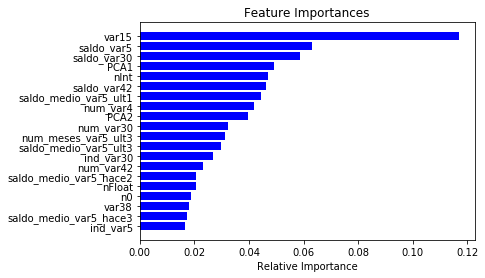

In [95]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(20), importances[indices][:20], color='b', align='center')
plt.yticks(range(20), train_X.columns[indices][:20])
plt.xlabel('Relative Importance')

As <em>features</em> que adicionamos, `PCA1`, `PCA2`, `nInt`, `nFloat` e `n0` foram boas intuições\.  
De fato, elas aparecem nas 20 <em>features</em> mais importantes.

Salvamos esse arvore que vai servir mais tarde.

In [96]:
dump(rf, 'random_forest.joblib')

['random_forest.joblib']

<a name='3-2-2'></a>
#### 3.2.2 Gradient Boost

Testamos aqui com o modelo de `gradient boost`\.  
Esse modelo utiliza arvores. A cada iteração, o novo preditor recebe como input os erros residuais dos resultados do preditor anterior\.  
Vamos utilizar uma versão melhorada do `gradient boost`: `XGBoost`, mais regularizada, a fim de minimizar o `overfit`.

In [42]:
clf = XGBClassifier(scale_pos_weight=96)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
clf.fit(train_X, train_Y)

print("Test on training set")
train_pred = clf.predict_proba(train_X)[:,1]
print_scores(train_Y,train_pred)
print()
print("Test on test set")
predictions = clf.predict_proba(test_X)[:,1]
print_scores(test_Y,predictions)

Test on training set
ROC AUC score: 0.8610484965751461

Test on test set
ROC AUC score: 0.8497811363391262


Dos principais metodos que utilizam arvores sem ter otimizado os hiperparametros pelo `grid search`, o `XGboost` foi aquele que atingiu os melhores resultados\.  

<a name='3-3'></a>
### 3.3 Otimizar o modelo mais promissor

In [43]:
ratio = float(np.sum(train_df[target_name] == 0)) / np.sum(train_df[target_name]==1)
clf = XGBClassifier(scale_pos_weight=ratio)
clf.fit(train_X, train_Y)

print("Test on training set")
train_pred = clf.predict_proba(train_X)[:,1]
print_scores(train_Y,train_pred)
print()
print("Test on test set")
predictions = clf.predict_proba(test_X)[:,1]
print_scores(test_Y,predictions)

Test on training set
ROC AUC score: 0.8617941072958192

Test on test set
ROC AUC score: 0.8500555833383767


Alterando um pouco o parametro `scale_pos_weight`, conseguimos um melhor score `AUC`\.    
Vamos utilizar as funções de automatização da busca dos hiperparametros\.  
A biblioteca `hyperopt` utiliza a otimização bayesiana para restringir aos poucos o escopo de busca\.  
Enquanto a `grid-search` tenta todas as combinações possíveis de hiperparâmetros dentro de alguns intervalos, a `hyperopt` não tenta todas as combinações, pois ela pesquisa ao longo do espaço de hiperparâmetros aprendendo enquanto os experimenta\.  
Isso permite evitar as tentativas de execução de todas as combinações.

In [78]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.fmin import generate_trials_to_calculate

def objective(space):

    clf = XGBClassifier(n_estimators = 10000, 
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            scale_pos_weight = space['scale_pos_weight'])

    eval_set  = [( train_X, train_Y), ( test_X, test_Y)]

    clf.fit(train_X, train_Y,
            eval_set=eval_set, eval_metric="auc", 
            early_stopping_rounds=3)

    pred = clf.predict_proba(test_X)[:,1]
    auc = roc_auc_score(test_Y, pred)
    print("SCORE:", auc)

    return{'loss':1-auc, 'status': STATUS_OK }


space ={
        'max_depth': hp.choice('x_max_depth', np.arange(1, 30, dtype=int)),
        'min_child_weight': hp.choice('x_min_child', np.arange(1, 10, dtype=int)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform ('x_scale_pos_weight', 20.0, 40.0)
    }


trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=59,
            trials=trials)

In [86]:
from hyperopt import space_eval

print("Best configuration: ", space_eval(space, best))

Best configuration:  {'max_depth': 5, 'min_child_weight': 6, 'scale_pos_weight': 27.286844726592925, 'subsample': 0.985487424804545}


In [41]:
clf = XGBClassifier(max_depth= 5, min_child_weight= 6, scale_pos_weight= 27.286844726592925, subsample= 0.985487424804545)

clf.fit(train_X, train_Y)

In [40]:
print("Test on training set")
train_pred = clf.predict_proba(train_X)[:,1]
print_scores(train_Y,train_pred)
print()
print("Test on test set")
predictions = clf.predict_proba(test_X)[:,1]
print_scores(test_Y,predictions)

Test on training set
ROC AUC score: 0.8969073628487679

Test on test set
ROC AUC score: 0.8655379794758502


Chegamos a um valor de `AUC` satisfatório\.  
Salvamos esse modelo para podermos reutiliza-lo.

In [79]:
dump(clf, 'xgboost_hyperopt.joblib')

['xgboost_hyperopt.joblib']

Agora implementamos o pipeline de preprocessamento do <em>dataset</em> para podermos prever os resultados do <em>test set</em> fornecido no Kaggle.

In [5]:
target_name = 'TARGET'
id_var_name = 'ID'

constants = ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28',
'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0',
'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0',
'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46',
'imp_amort_var18_hace3', 'imp_amort_var34_hace3',
'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3',
'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3',
'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3',
'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3',
'num_trasp_var33_out_hace3', 'saldo_var2_ult1',
'saldo_medio_var13_medio_hace3']

duplicated = ['ind_var29_0','ind_var29','ind_var13_medio','ind_var18',
'ind_var26','ind_var25','ind_var32','ind_var34','ind_var37','ind_var39',
'num_var29_0','num_var29','num_var13_medio','num_var18','num_var26','num_var25',
'num_var32','num_var34','num_var37','num_var39','saldo_var29','saldo_medio_var13_medio_ult1',
'delta_num_reemb_var13_1y3','delta_num_reemb_var17_1y3','delta_num_reemb_var33_1y3','delta_num_trasp_var17_in_1y3',
'delta_num_trasp_var17_out_1y3','delta_num_trasp_var33_in_1y3','delta_num_trasp_var33_out_1y3']


def pipeline_preprocess(df, constants, duplicated):
    df = df.drop(constants, axis=1)
    df.drop(duplicated, axis=1, inplace=True)
    if target_name in df.columns:
        drop_cols = [id_var_name, target_name]
    else:
        drop_cols = [id_var_name]

    df['n0'] = (df.drop(drop_cols, axis=1) == 0).sum(axis=1)
    integer_cols = df.columns[df.dtypes == 'int64']
    df['nInt'] = (df[integer_cols].drop(drop_cols + ["n0"], axis=1) ).sum(axis=1)
    float_cols = df.columns[df.dtypes == 'float64']
    df['nFloat'] = (df[float_cols]).sum(axis=1)

    pca = PCA(n_components=2)
    scaler = StandardScaler()
    if target_name in df.columns:
        df_scaled = scaler.fit_transform(df.drop([id_var_name, target_name], axis=1))
    else:
        df_scaled = scaler.fit_transform(df.drop([id_var_name], axis=1))
    X_pca = pca.fit_transform(df_scaled)
    df['PCA1'] = X_pca[:,0]
    df['PCA2'] = X_pca[:,1]
    return df

In [8]:
train_df = pd.read_csv('/home/container/t732787/Auto ML Tests/data/santander_customer_satisfaction.csv.zip')
train_df = pipeline_preprocess(train_df, constants, duplicated)
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET,n0,nInt,nFloat,PCA1,PCA2
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,39205.170000,0,292,145,3.920517e+04,-2.991040,-1.324631
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,49278.030000,0,266,94,5.152789e+04,-0.314305,7.919896
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,67333.770000,0,277,162,6.735102e+04,-2.010928,-0.760597
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,64007.970000,0,248,293,6.584127e+04,4.157182,-1.723514
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,117310.979016,0,256,135,1.287339e+06,3.166553,8.108164


In [39]:
clf = load('xgboost_hyperopt.joblib')

print("Test on training set")
train_pred = clf.predict_proba(train_X)[:,1]
print_scores(train_Y,train_pred)
print()
print("Test on test set")
predictions = clf.predict_proba(test_X)[:,1]
print_scores(test_Y,predictions)

Test on training set
ROC AUC score: 0.8969073628487679

Test on test set
ROC AUC score: 0.8655379794758502


In [85]:
test = pd.read_csv("/home/container/t732787/Auto ML Tests/data/test.csv")
test_id = test.ID

### Submission
probs = clf.predict_proba(pipeline_preprocess(test, constants, duplicated).drop(["ID"],axis=1))

submission = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})
submission.to_csv("submission.csv", index=False)

No Kaggle, chegamos a um score de 0.83116\.  
Utilizaremos esse modelo de XGBoost para a resolução do caso.

<a name='4'></a>
## 4. Resolução do caso

<a name='4-1'></a>
### 4.1 Maximizar o lucro esperado por cliente

Utilizaremos os <em>outputs</em> de probabilidade do modelo da parte 3 para calibrar o <em>threshold</em>, a fim de maximizar o lucro.

In [90]:
clf = load('xgboost_hyperopt.joblib')

# we have to maximize 90 * TP - FP * 10
def max_fun(nb_TPs, nb_FPs):
    return nb_TPs * 90 - nb_FPs * 10

# get the strategy that maximizes the precedent funcion
def get_strategy_table_TP_FP_MaxFun(model_to_test, test_X, test_Y, max_fun):
    """
        - the default class here is the insatisfied customer
        - the acceptance rate here is the percentage of as satisfied considered customers
    """
    preds_df = pd.DataFrame()
    preds_df['prob_default'] = model_to_test.predict_proba(test_X)[:,1]
    preds_df['pred_default'] = model_to_test.predict(test_X)
    preds_df['true_default'] = np.ravel(test_Y)
    
    accept_rates = np.arange(0.05,1.05,0.05)
    
    ## Making the strategy table
    # Populate the arrays for the strategy table with a for loop
    thresholds = []
    # bad_rates = []
    
    TPs = []
    FPs = []
    to_maximize = []
    for rate in accept_rates:
        # Calculate the threshold for the acceptance rate
        thresh = np.quantile(preds_df['prob_default'], rate).round(3)
        # Add the threshold value to the list of thresholds
        thresholds.append(np.quantile(preds_df['prob_default'], rate).round(3))
        # Reassign the loan_status value using the threshold
        preds_df['pred_default'] = preds_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
        
        TP = preds_df[(preds_df['pred_default'] == 1) & (preds_df['true_default'] == 1)]
        FP = preds_df[(preds_df['pred_default'] == 1) & (preds_df['true_default'] == 0)]
        
        nb_TPs = len(TP)
        nb_FPs = len(FP)
        TPs.append(nb_TPs)
        FPs.append(nb_FPs)

        to_maximize.append(max_fun(nb_TPs, nb_FPs))
        
    
    # Create a data frame of the strategy table
    strat_df = pd.DataFrame(zip(accept_rates, thresholds, TPs, FPs, to_maximize),
                            columns = ['Acceptance Rate','Threshold','TPs', 'FPs', 'To Maximize'])
    
    
    # Print the entire table
    print(strat_df)
    row_max_estimated_value = strat_df.loc[strat_df['To Maximize'] == strat_df['To Maximize'].max()]
    max_benef_threshold = np.ravel(row_max_estimated_value['Threshold'])[0] 
    return preds_df, strat_df, row_max_estimated_value, max_benef_threshold


In [91]:
preds_df, strat_df, row_max_estimated_value, max_benef_threshold = get_strategy_table_TP_FP_MaxFun(clf, test_X, test_Y, max_fun)

    Acceptance Rate  Threshold  TPs    FPs  To Maximize
0              0.05      0.022  601  13826       -84170
1              0.10      0.030  601  13064       -76550
2              0.15      0.042  600  12313       -69130
3              0.20      0.055  599  11550       -61590
4              0.25      0.076  598  10796       -54140
5              0.30      0.105  597  10034       -46610
6              0.35      0.135  588   9285       -39930
7              0.40      0.172  579   8542       -33310
8              0.45      0.206  574   7792       -26260
9              0.50      0.240  568   6959       -18470
10             0.55      0.281  559   6279       -12480
11             0.60      0.323  538   5550        -7080
12             0.65      0.379  520   4795        -1150
13             0.70      0.439  490   4062         3480
14             0.75      0.484  471   3334         9050
15             0.80      0.566  428   2608        12440
16             0.85      0.669  375   1906      

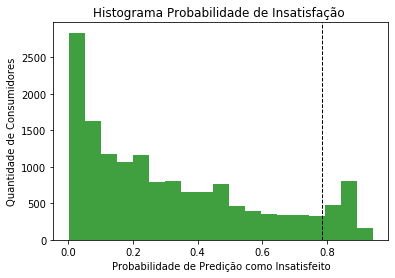

Threshold de beneficio maximo: 0.786


In [92]:
# Plot a histogram of the prediction probability
plt.hist(clf.predict_proba(test_X)[:,1], 19, density=False, facecolor='g', alpha=0.75)
plt.axvline(max_benef_threshold, color='k', linestyle='dashed', linewidth=1)

plt.xlabel('Probabilidade de Predição como Insatisfeito')
plt.ylabel('Quantidade de Consumidores')
plt.title('Histograma Probabilidade de Insatisfação ')

# Show the plot
plt.show()
print("Threshold de beneficio maximo:",max_benef_threshold)

Podemos interpretar a tabela e o grafico da seguinte maneira:  
Com o threshold de 0.786 (barra vertical no grafico), chegamos a um bom compromisso entre a quantidade de verdadeiros positivos e a quantidade de falsos positivos que maximiza o valor resultando da estrategia de campanhas\.  
Com essa escolha de <em>threshold</em> (`max_benef_threshold`), mais ou menos 10% da população é prevista como insatisfeita, ou seja, a ação de retenção sera feita em 10% dos consumidores.

<a name='4-2'></a>
### 4.2 Atribuir uma nota de 1 a 5 para cada cliente

A segunda tarefa consiste em dar uma nota de
1 a 5 para cada cliente da base teste, respeitando
a variável `TARGET`, isto é, o seu nível de satisfação,
sendo 1 o mais insatisfeito e 5 o mais satisfeito\.  
Ao dar essa nota deve-se ter em mente que
somente os clientes com nota 1 serão alvos de
uma ação de retenção e que o objetivo dessa
ação é maximizar o lucro esperado por cliente
(usando os mesmos valores da primeira questão).

Olhando pro gráfico anterior (Histograma Probabilidade de Insatisfação) podemos separar 5 picos de densidade populacional\. Assim poderiamos nos basear nisso para atribuir uma nota de satisfação, com o requisito de associar a nota 1 aos consumidores que terão uma ação de retenção:

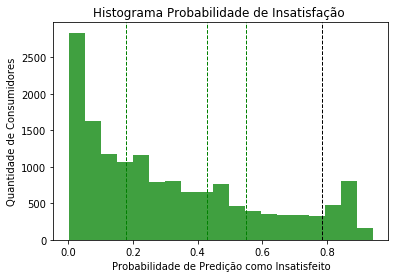

In [93]:
# Plot a histogram of the prediction probability
plt.hist(clf.predict_proba(test_X)[:,1], 19, density=False, facecolor='g', alpha=0.75)
plt.axvline(max_benef_threshold, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.55, color='g', linestyle='dashed', linewidth=1)
plt.axvline(0.43, color='g', linestyle='dashed', linewidth=1)
plt.axvline(0.18, color='g', linestyle='dashed', linewidth=1)

plt.xlabel('Probabilidade de Predição como Insatisfeito')
plt.ylabel('Quantidade de Consumidores')
plt.title('Histograma Probabilidade de Insatisfação ')

# Show the plot
plt.show()

Da direita para a esquerda, conseguimos atribuir as notas 1, 2, 3, 4, 5 aos grupos delimitados pelas barras verticais\.  
Vamos enriquecer o dataset completo com a coluna "Nota cliente":

In [94]:
dict_notes = {1:[max_benef_threshold,1],
2:[0.55,max_benef_threshold],
3:[0.43,0.55],
4:[0.18,0.43],
5:[0,0.18]}

# get key from dict values
def get_assoc_key(x):
    for k,v in dict_notes.items():
        if x >= v[0] and x < v[1]:
            return k
    return None

predictions_wholedataset = clf.predict_proba(train_df.drop([id_var_name, target_name], axis=1))[:,1]
train_df["Nota Cliente"] = pd.Series(predictions_wholedataset).apply(lambda x : get_assoc_key(x))
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET,n0,nInt,nFloat,PCA1,PCA2,Nota Cliente
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,39205.170000,0,292,145,3.920517e+04,-2.991033,-1.324461,3
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,49278.030000,0,266,94,5.152789e+04,-0.314298,7.920635,5
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,67333.770000,0,277,162,6.735102e+04,-2.010931,-0.760778,5
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,64007.970000,0,248,293,6.584127e+04,4.157179,-1.723632,4
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,117310.979016,0,256,135,1.287339e+06,3.166552,8.108341,4


<a name='4-3'></a>
### 4.3 Encontrar os três grupos naturais que possuem os maiores lucros

Todo conjunto de dados é passível de ser
dividido em grupos coesos, conhecidos como
agrupamentos naturais. A terceira tarefa é
encontrar os três grupos naturais que possuem
os maiores lucros esperados por cliente (usando
os mesmos valores da primeira questão).

Vamos utilizar o `k-mean` como algoritmo de clusterização\.  
Para achar a quantidade de <em>clusters</em> otimal, vamos utilizar o metodo de <em>Elbow Curve</em>.

`k-mean` é sensivel aos outliers e a escala\.  
Todavia, não temos definições claras das 371 colunas e pode ser que a normalização das colunas númericas gere uma clusterização ineficiente\.  
Muitas colunas são de menor importancia e causam ruidos para um metodo de clusterização como k-mean que não esta adequado a muitas dimensões\.  
Vamos utilizar primeiro a funcionalidade do algoritmo de `random forest` de avaliação da importancia dos <em>features</em>.

In [13]:
rf = load('random_forest.joblib')

print("Test on training set")
train_pred = rf.predict_proba(train_X)[:,1]
print_scores(train_Y,train_pred)
print()
print("Test on test set")
predictions = rf.predict_proba(test_X)[:,1]
print_scores(test_Y,predictions)

Test on training set
ROC AUC score: 0.8313555838144291

Test on test set
ROC AUC score: 0.8227273030956288


Text(0.5, 0, 'Relative Importance')

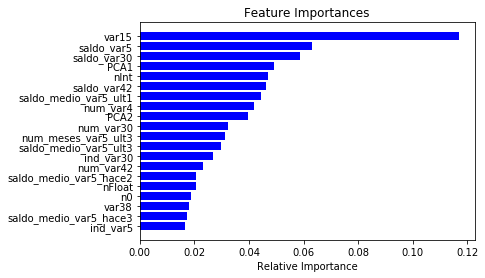

In [14]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(20), importances[indices][:20], color='b', align='center')
plt.yticks(range(20), train_X.columns[indices][:20])
plt.xlabel('Relative Importance')

Percebemos que a importancia dos <em>features</em> diminui bastante apos o 15° mais importante\.  
Desconsiderar as outras colunas não deveria afetar muito a performance de um modelo de previsão\.  
Isso deveria ajudar tambem o algoritmo `k-mean` a separar mais facilmente os grupos coesos naturais.

In [15]:
selected_features = train_X.columns[indices][:20]
selected_features

Index(['ind_var5', 'saldo_medio_var5_hace3', 'var38', 'n0', 'nFloat',
       'saldo_medio_var5_hace2', 'num_var42', 'ind_var30',
       'saldo_medio_var5_ult3', 'num_meses_var5_ult3', 'num_var30', 'PCA2',
       'num_var4', 'saldo_medio_var5_ult1', 'saldo_var42', 'nInt', 'PCA1',
       'saldo_var30', 'saldo_var5', 'var15'],
      dtype='object')

In [16]:
train_df = pd.read_csv('/home/container/t732787/Auto ML Tests/data/santander_customer_satisfaction.csv.zip')
train_df = pipeline_preprocess(train_df, constants, duplicated)
train_X_unsupervised = train_df[selected_features]
train_X_unsupervised.head()

,ind_var5,saldo_medio_var5_hace3,var38,n0,nFloat,saldo_medio_var5_hace2,num_var42,ind_var30,saldo_medio_var5_ult3,num_meses_var5_ult3,num_var30,PCA2,num_var4,saldo_medio_var5_ult1,saldo_var42,nInt,PCA1,saldo_var30,saldo_var5,var15
0,0,0.00,39205.170000,292,3.920517e+04,0.00,0,0,0.00,0,0,-1.324995,0,0.00,0.00,145,-2.991033,0.00,0.00,23
1,0,88.89,49278.030000,266,5.152789e+04,0.00,0,1,0.00,1,3,7.919637,1,0.00,0.00,94,-0.314288,300.00,0.00,34
2,1,0.18,67333.770000,277,6.735102e+04,3.00,3,1,2.07,3,3,-0.760477,1,3.00,3.00,162,-2.010934,3.00,3.00,23
3,1,0.00,64007.970000,248,6.584127e+04,186.09,3,1,138.84,2,3,-1.722382,3,91.56,70.62,293,4.157192,70.62,70.62,37
4,0,0.30,117310.979016,256,1.287339e+06,3.00,3,1,13501.47,3,3,8.107825,1,40501.08,135003.00,135,3.166557,135003.00,0.00,39


Existem muitos `outliers` no <em>dataset</em>\.  
Podemos utilizar o grafico `boxplot` para visualiza-los.

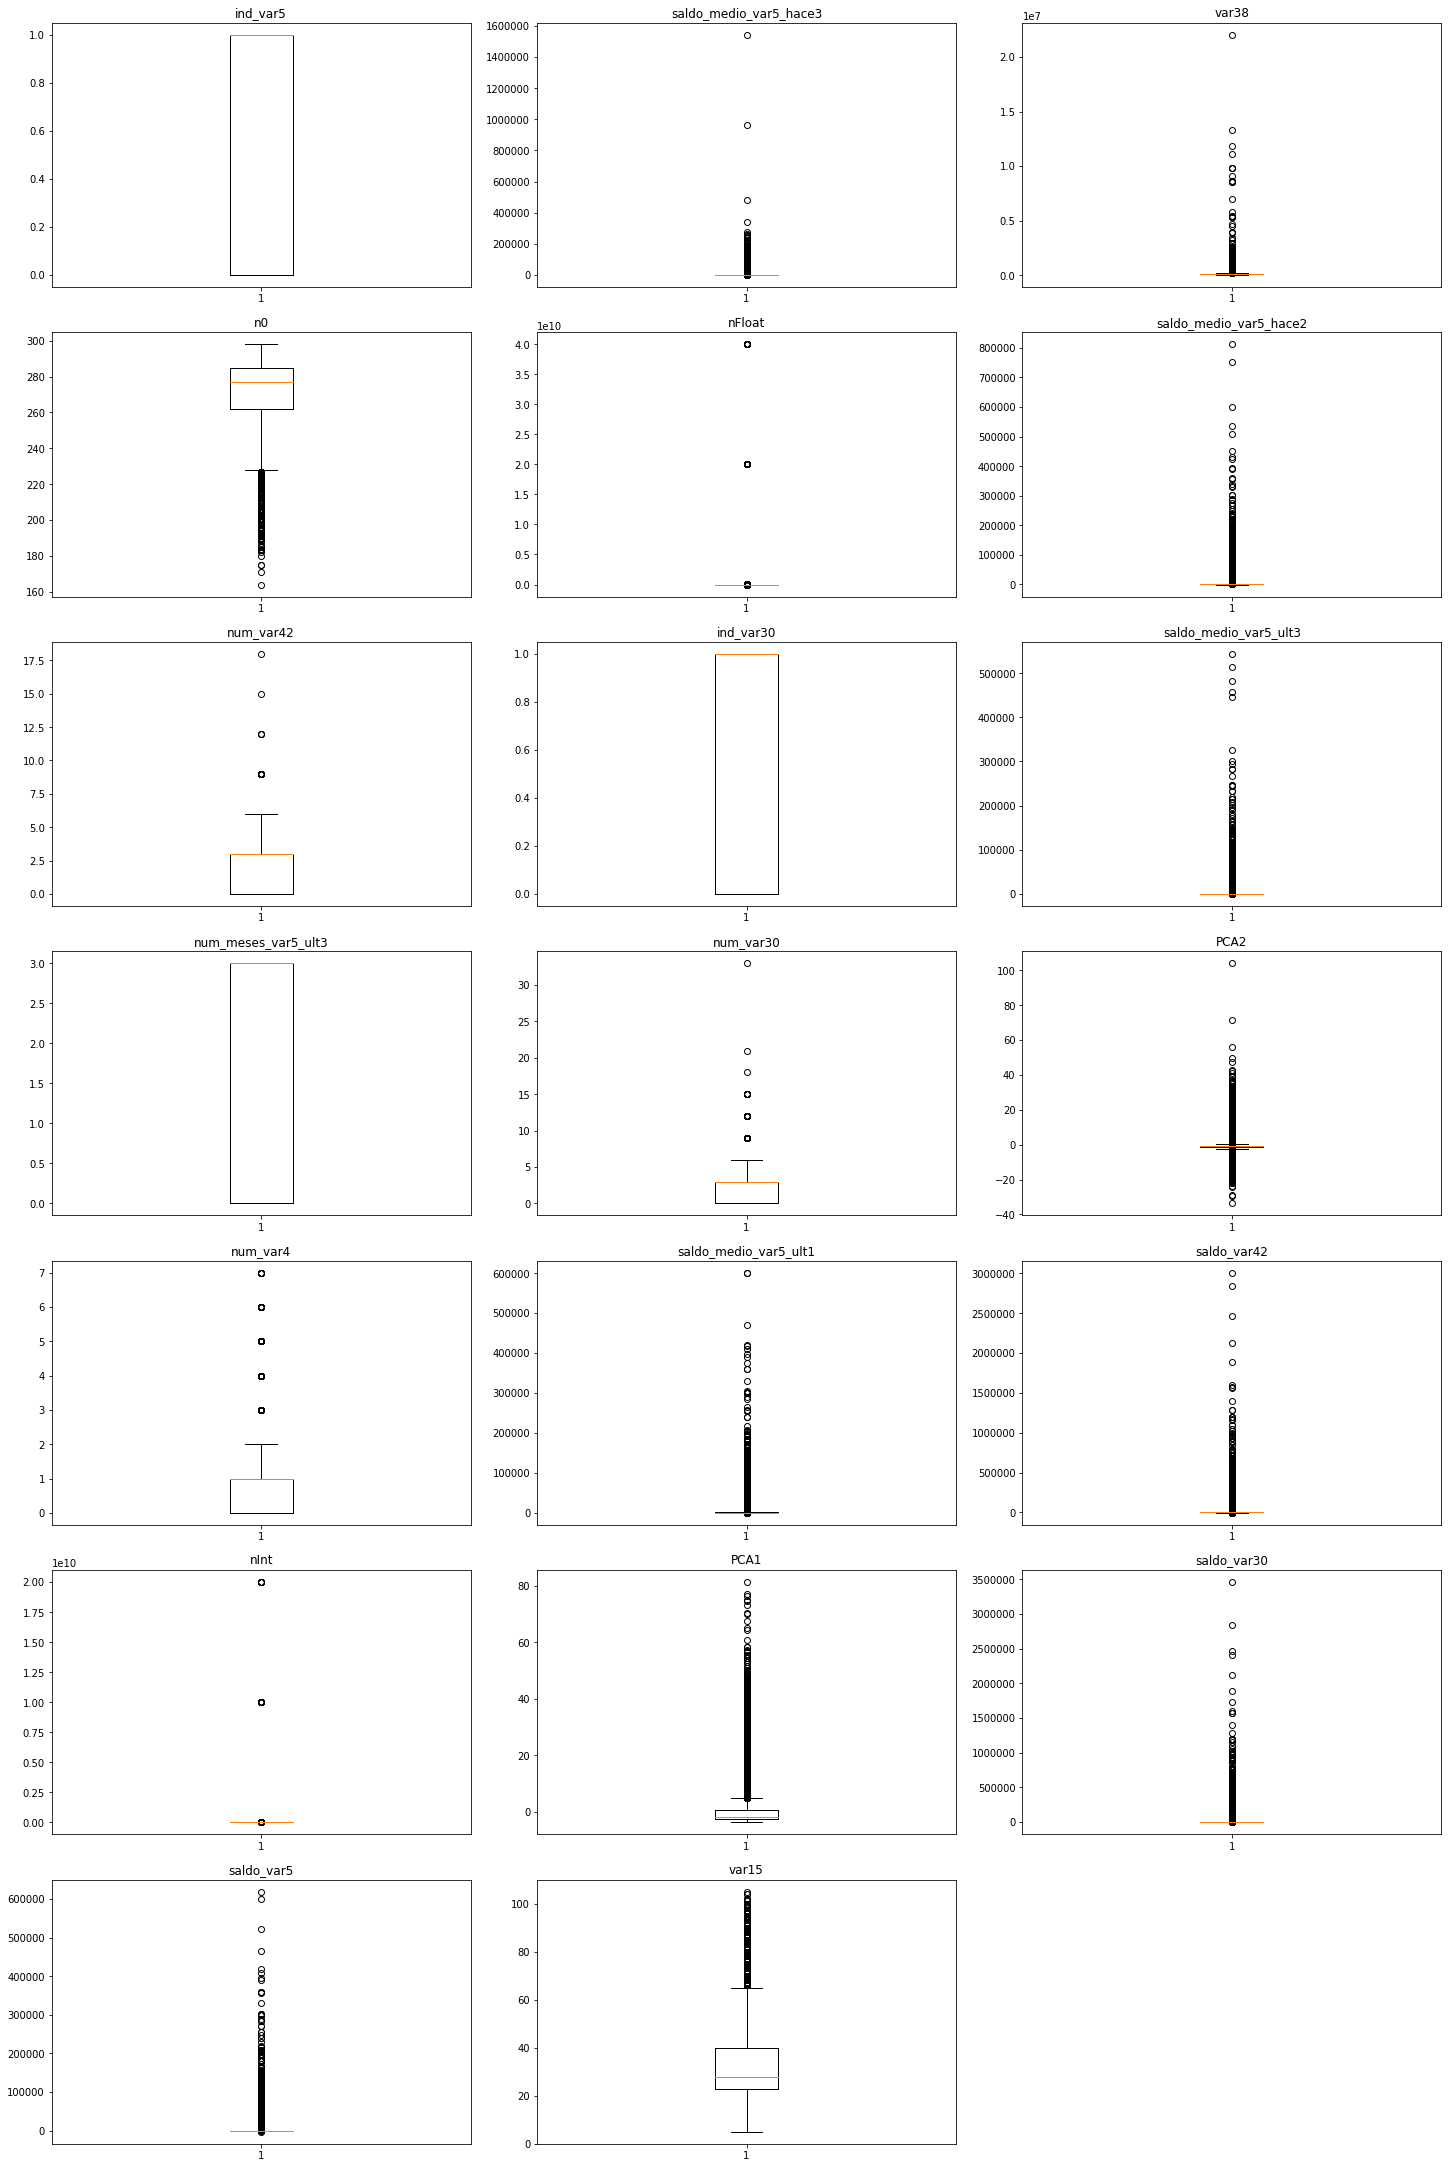

In [19]:
def draw_boxplots(df, n):
    fig = plt.figure(constrained_layout=True, figsize=(20, 30))
    gs = gridspec.GridSpec(int(n/3) + 1, 3, figure=fig)

    for i in range(n):
        k = int(i / 3)
        j = i % 3
        col = selected_features[i]
        ax = fig.add_subplot(gs[k, j])
        ax.set_title(col)
        ax.boxplot(df[col])

draw_boxplots(train_X_unsupervised, n=len(selected_features))

In [20]:
def replace_outliers(dataframe, var_names):
    df = dataframe.copy()
    for var_name in var_names:
        Q1 = df.loc[:,var_name].quantile(0.25)
        Q3 = df.loc[:,var_name].quantile(0.75)
        IQR = Q3 - Q1
    

        filter_up = (df.loc[:,var_name] > Q3 + 1.5 *IQR)
        df.loc[filter_up, var_name] = Q3 + 1.5 *IQR
        filter_down = (df.loc[:,var_name] < Q1 - 1.5 * IQR)
        df.loc[filter_down, var_name] = Q1 - 1.5 * IQR
    return df

replace_outliers(train_X_unsupervised, selected_features).head()

,ind_var5,saldo_medio_var5_hace3,var38,n0,nFloat,saldo_medio_var5_hace2,num_var42,ind_var30,saldo_medio_var5_ult3,num_meses_var5_ult3,num_var30,PCA2,num_var4,saldo_medio_var5_ult1,saldo_var42,nInt,PCA1,saldo_var30,saldo_var5,var15
0,0.0,0.00000,39205.170000,292.0,39205.17,0.00,0.0,0.0,0.000,0.0,0.0,-1.324995,0.0,0.00,0.00,145.0,-2.991033,0.0000,0.00,23.0
1,0.0,30.54375,49278.030000,266.0,51527.89,0.00,0.0,1.0,0.000,1.0,3.0,0.575973,1.0,0.00,0.00,94.0,-0.314288,300.0000,0.00,34.0
2,1.0,0.18000,67333.770000,277.0,67351.02,3.00,3.0,1.0,2.070,3.0,3.0,-0.760477,1.0,3.00,3.00,162.0,-2.010934,3.0000,3.00,23.0
3,1.0,0.00000,64007.970000,248.0,65841.27,186.09,3.0,1.0,138.840,2.0,3.0,-1.722382,2.5,91.56,70.62,293.0,4.157192,70.6200,70.62,37.0
4,0.0,0.30000,117310.979016,256.0,265404.36,3.00,3.0,1.0,209.475,3.0,3.0,0.575973,1.0,225.00,300.00,135.0,3.166557,589.9875,0.00,39.0


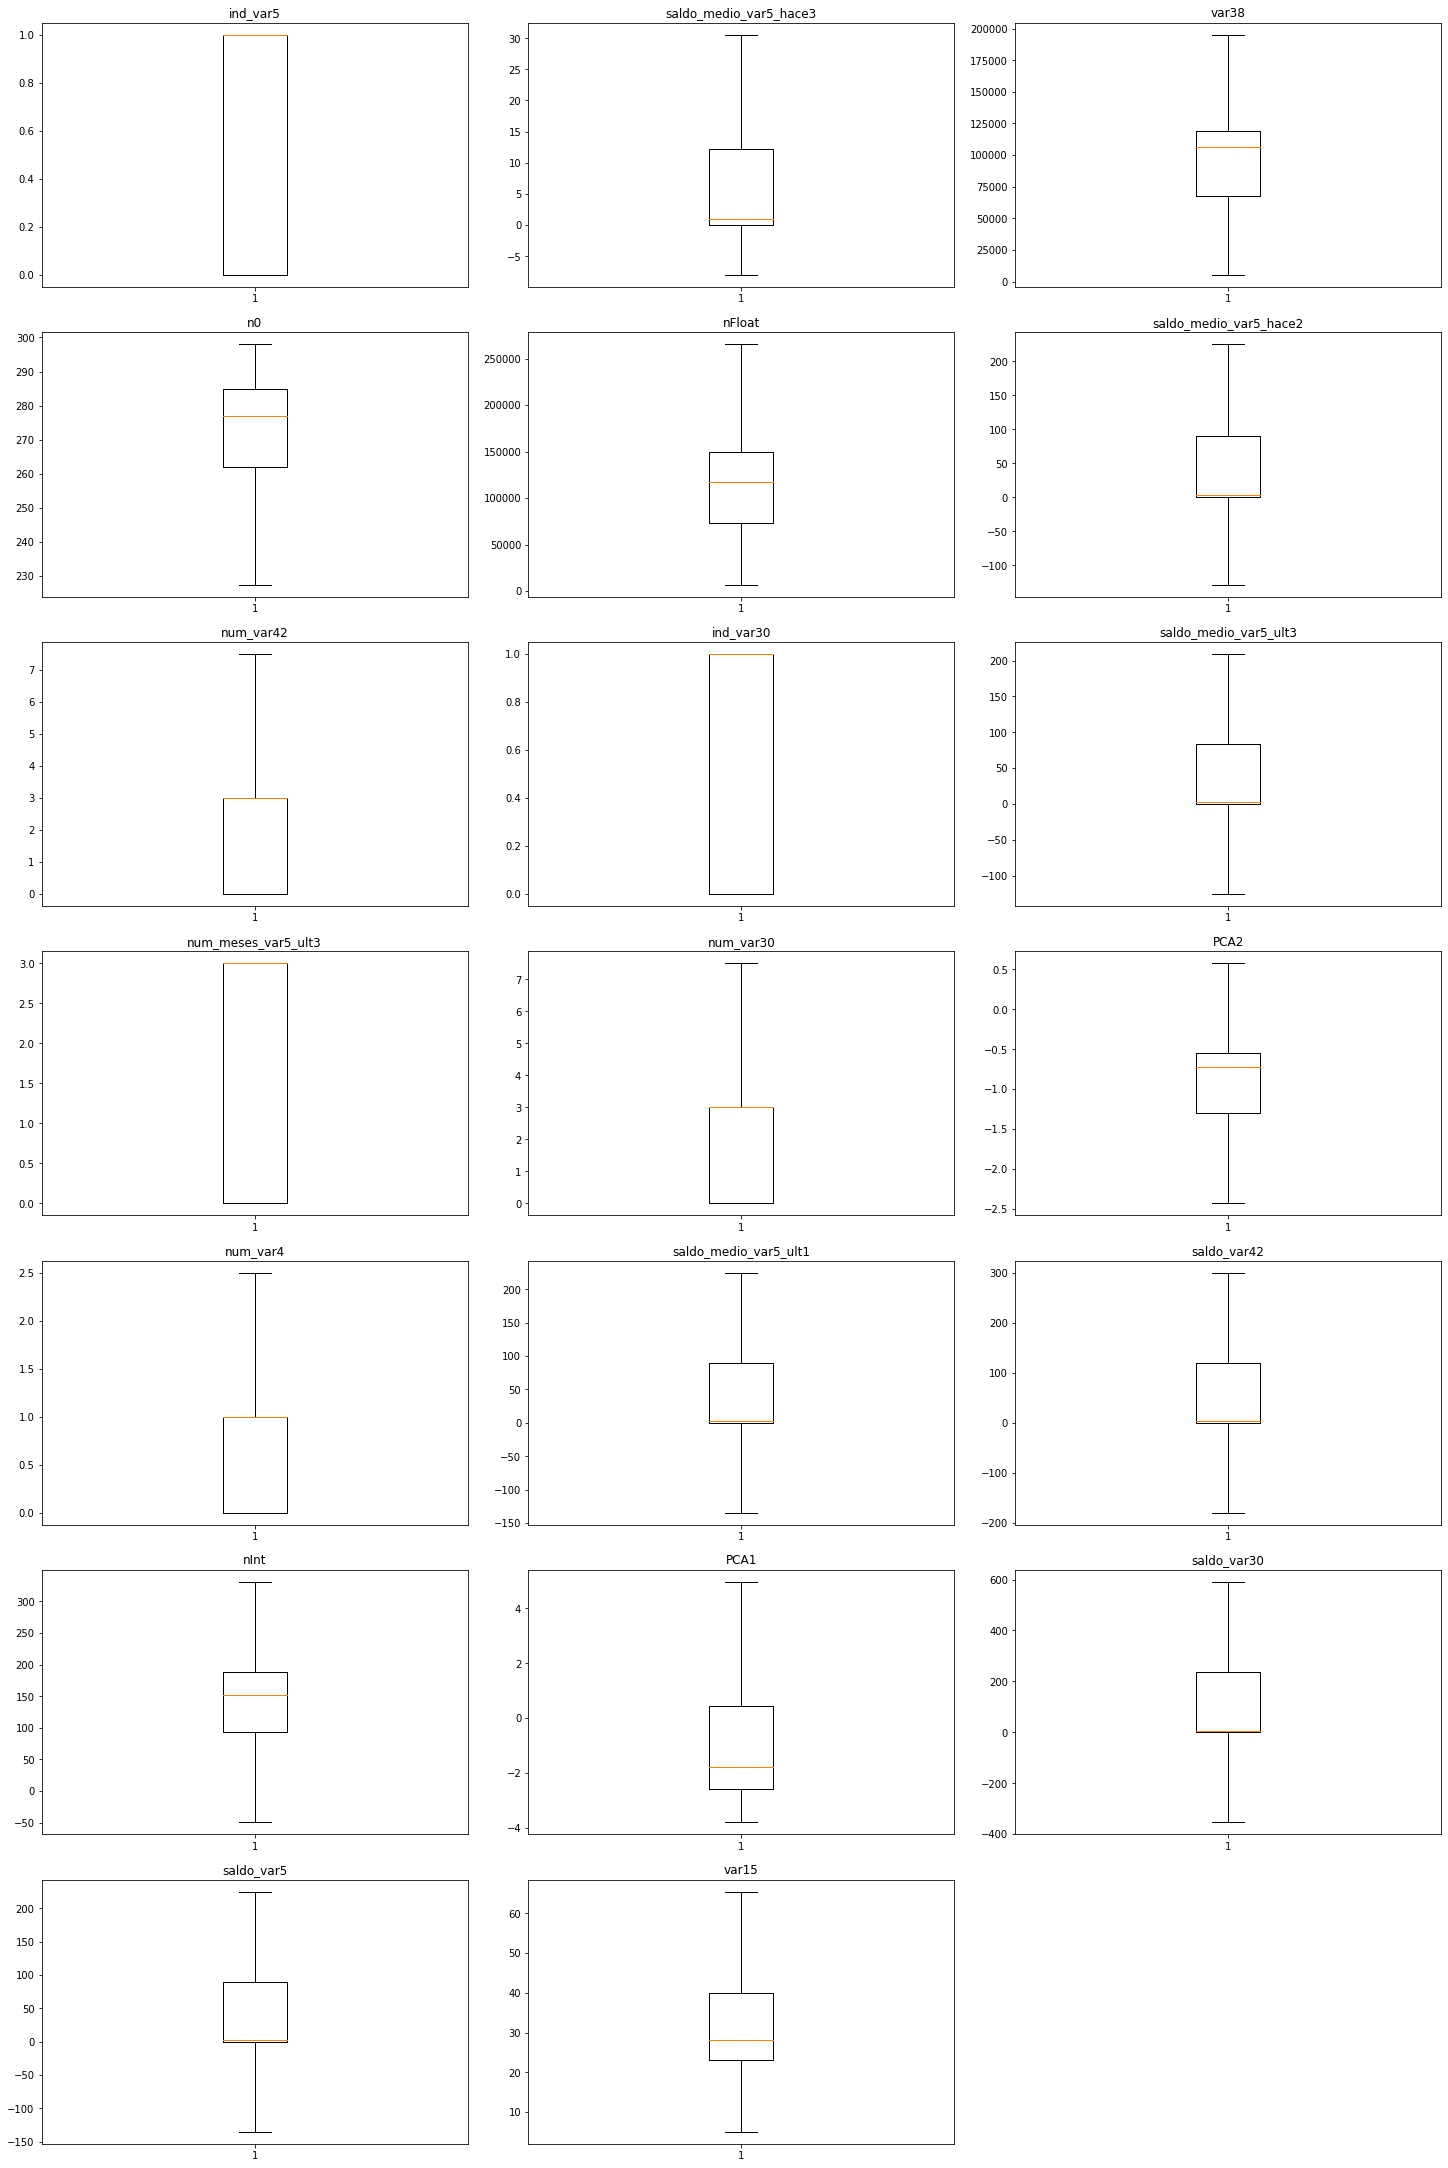

In [21]:
draw_boxplots(replace_outliers(train_X_unsupervised, selected_features), n=len(selected_features))

A função acima tirou todos os outliers com a consideração do [box plot](https://en.wikipedia.org/wiki/Box_plot).

In [22]:
train_X_unsupervised_nooutlier = replace_outliers(train_X_unsupervised, selected_features)
train_X_unsupervised_nooutlier.head()

,ind_var5,saldo_medio_var5_hace3,var38,n0,nFloat,saldo_medio_var5_hace2,num_var42,ind_var30,saldo_medio_var5_ult3,num_meses_var5_ult3,num_var30,PCA2,num_var4,saldo_medio_var5_ult1,saldo_var42,nInt,PCA1,saldo_var30,saldo_var5,var15
0,0.0,0.00000,39205.170000,292.0,39205.17,0.00,0.0,0.0,0.000,0.0,0.0,-1.324995,0.0,0.00,0.00,145.0,-2.991033,0.0000,0.00,23.0
1,0.0,30.54375,49278.030000,266.0,51527.89,0.00,0.0,1.0,0.000,1.0,3.0,0.575973,1.0,0.00,0.00,94.0,-0.314288,300.0000,0.00,34.0
2,1.0,0.18000,67333.770000,277.0,67351.02,3.00,3.0,1.0,2.070,3.0,3.0,-0.760477,1.0,3.00,3.00,162.0,-2.010934,3.0000,3.00,23.0
3,1.0,0.00000,64007.970000,248.0,65841.27,186.09,3.0,1.0,138.840,2.0,3.0,-1.722382,2.5,91.56,70.62,293.0,4.157192,70.6200,70.62,37.0
4,0.0,0.30000,117310.979016,256.0,265404.36,3.00,3.0,1.0,209.475,3.0,3.0,0.575973,1.0,225.00,300.00,135.0,3.166557,589.9875,0.00,39.0


O metodo de clusterização `k-mean` pode ser afetado pelas diferenças de escala dos valores do <em>dataset</em>\.  
Não temos uma visibilidade clara sobre o que cada coluna é, então a normalização das colunas tambem podem afetar negativamente a separação dos clusters\.  
Vamos visualizar o grafico <em>Elbow Curve</em> com o <em>dataset</em> sem e com normalização do <em>dataset</em>.

In [24]:
scaler = StandardScaler()
train_X_unsupervised = train_df.drop([id_var_name, target_name], axis=1)[selected_features]
train_X_unsupervised.head()

,ind_var5,saldo_medio_var5_hace3,var38,n0,nFloat,saldo_medio_var5_hace2,num_var42,ind_var30,saldo_medio_var5_ult3,num_meses_var5_ult3,num_var30,PCA2,num_var4,saldo_medio_var5_ult1,saldo_var42,nInt,PCA1,saldo_var30,saldo_var5,var15
0,0,0.00,39205.170000,292,3.920517e+04,0.00,0,0,0.00,0,0,-1.324995,0,0.00,0.00,145,-2.991033,0.00,0.00,23
1,0,88.89,49278.030000,266,5.152789e+04,0.00,0,1,0.00,1,3,7.919637,1,0.00,0.00,94,-0.314288,300.00,0.00,34
2,1,0.18,67333.770000,277,6.735102e+04,3.00,3,1,2.07,3,3,-0.760477,1,3.00,3.00,162,-2.010934,3.00,3.00,23
3,1,0.00,64007.970000,248,6.584127e+04,186.09,3,1,138.84,2,3,-1.722382,3,91.56,70.62,293,4.157192,70.62,70.62,37
4,0,0.30,117310.979016,256,1.287339e+06,3.00,3,1,13501.47,3,3,8.107825,1,40501.08,135003.00,135,3.166557,135003.00,0.00,39


In [25]:
scaled_numerical = scaler.fit_transform(train_X_unsupervised_nooutlier)
# Remove Nan and infinite values
scaled_numerical = np.nan_to_num(scaled_numerical)

# Build a DataFrame from scaled_numerical
scaled_numerical = pd.DataFrame(scaled_numerical, columns=train_X_unsupervised.columns)
scaled_numerical.head()

,ind_var5,saldo_medio_var5_hace3,var38,n0,nFloat,saldo_medio_var5_hace2,num_var42,ind_var30,saldo_medio_var5_ult3,num_meses_var5_ult3,num_var30,PCA2,num_var4,saldo_medio_var5_ult1,saldo_var42,nInt,PCA1,saldo_var30,saldo_var5,var15
0,-1.405013,-0.656839,-1.437627,1.135932,-1.243840,-0.678024,-1.485146,-1.656196,-0.675247,-1.524332,-1.480877,-0.680023,-1.329266,-0.666898,-0.678618,-0.208692,-0.868777,-0.653231,-0.635319,-0.827295
1,-1.405013,1.850302,-1.214311,-0.402680,-1.065118,-0.678024,-1.485146,0.603793,-0.675247,-0.754459,0.390824,1.895267,-0.028130,-0.666898,-0.678618,-0.843781,0.147760,0.605713,-0.635319,0.090785
2,0.711737,-0.642064,-0.814016,0.248271,-0.835628,-0.642923,0.524552,0.603793,-0.649640,0.785287,0.390824,0.084744,-0.028130,-0.631999,-0.653565,0.003005,-0.496568,-0.640641,-0.599621,-0.827295
3,0.711737,-0.656839,-0.887749,-1.467874,-0.857525,1.499295,0.524552,0.603793,1.042275,0.015414,0.390824,-1.218372,1.923575,0.398214,-0.088869,1.634312,1.845876,-0.356875,0.205015,0.341170
4,-1.405013,-0.632214,0.293980,-0.994454,2.036825,-0.642923,0.524552,0.603793,1.916066,0.785287,0.390824,1.895267,-0.028130,1.950515,1.826687,-0.333219,1.469666,1.822639,-0.635319,0.508094


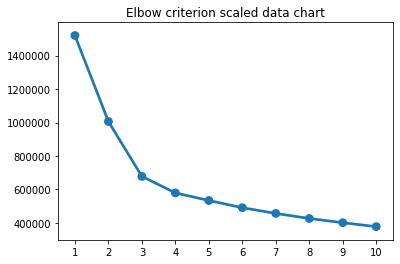

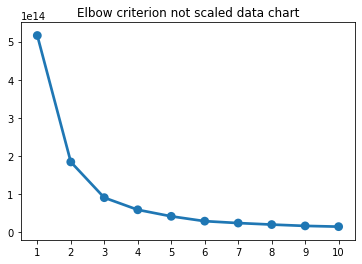

Quantidade de clusters otimal:  4


In [26]:
def find_optimal_k_elbow(df_norm_scaled, chart_name):
    # Create empty sse dictionary
    sse = {}
    
    # Fit KMeans algorithm on k values between 1 and 11
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=333)
        kmeans.fit(df_norm_scaled)
        sse[k] = kmeans.inertia_
    
    # Add the title to the plot
    plt.title('Elbow criterion ' + chart_name + ' data chart')
    
    # Create and display a scatter plot
    xx = list(sse.keys())
    yy = list(sse.values())
    sns.pointplot(x=xx, y=yy)
    plt.show()
    return xx,yy

def optimal_number_of_clusters(x1, x2, y1, y2, wcss):
    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2


def get_optimal_number_of_clusters(df_norm_scaled, chart_name):
    xx, yy = find_optimal_k_elbow(df_norm_scaled, chart_name)
    # calculating the within clusters sum-of-squares for 19 cluster amounts
    x1 = xx[0]
    y1 = yy[0]
    x2 = xx[len(xx)-1]
    y2 = yy[len(yy)-1]
    
    # calculating the optimal number of clusters
    n = optimal_number_of_clusters(x1, x2, y1, y2, yy)
    return n

p = get_optimal_number_of_clusters(scaled_numerical, chart_name="scaled")
n = get_optimal_number_of_clusters(train_X_unsupervised_nooutlier, chart_name="not scaled")
print("Quantidade de clusters otimal: ", n)

A segunda curva converge mais rapido para zero. A clusterização `k-mean` separa melhor os <em>clusters</em> quando não tem normalização do <em>dataset</em>\.  
Parece tambem que 4 é a quantidade de clusters mais adequada\.  
Vamos atribuir o label do cluster a cada registro do nosso <em>dataset</em>.

In [27]:
kmeans = KMeans(n_clusters=4, random_state=333)
kmeans.fit(train_X_unsupervised_nooutlier)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=333, tol=0.0001, verbose=0)

In [28]:
train_df_segment = train_df.assign(segment = kmeans.labels_)

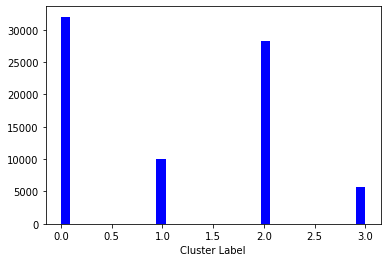

In [29]:
n, bins, patches = plt.hist(train_df_segment["segment"], bins='auto', color='blue')
hist_xlabel = ""
if hist_xlabel == "":
    plt.xlabel('Cluster Label')
else:
    plt.xlabel(hist_xlabel)
plt.show()

Aqui visualizamos a quantidade de clientes por <em>cluster</em>\.  
Vamos achar os 3 grupos de clientes os mais rentaveis.

In [30]:
clf = load('xgboost_hyperopt.joblib')
print("Test on training set")
train_pred = clf.predict_proba(train_X)[:,1]
print_scores(train_Y,train_pred)
print()
print("Test on test set")
predictions = clf.predict_proba(test_X)[:,1]
print_scores(test_Y,predictions)

Test on training set
ROC AUC score: 0.8969073628487679

Test on test set
ROC AUC score: 0.8655379794758502


In [33]:
max_benef_threshold = 0.786
predictions_wholedataset = (clf.predict_proba(train_df.drop([id_var_name, target_name], axis=1))[:,1] >= max_benef_threshold).astype(int)
predictions_wholedataset[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [34]:
train_df_segment["Prediction"] = predictions_wholedataset

In [35]:
train_df_segment["TP"] = ((train_df_segment["Prediction"] == 1) & (train_df_segment[target_name] == 1)).astype(int)

In [36]:
train_df_segment["FP"] = ((train_df_segment["Prediction"] == 1) & (train_df_segment[target_name] == 0)).astype(int)

In [38]:
segments_benefits = train_df_segment.groupby('segment', as_index=False).agg({"TP": "sum", "FP": "sum"})
pd.concat([segments_benefits, (90 * segments_benefits.iloc[:,1] - 10 * segments_benefits.iloc[:,2]).rename('lucro')], axis = 1)

,segment,TP,FP,lucro
0,0,612,2554,29540
1,1,24,33,1830
2,2,994,3285,56610
3,3,8,0,720


Os 3 grupos naturais mais rentaveis são os grupos 2, 0 e 1.